In [1]:
import uuid, sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast
import math
import random
import matplotlib.pyplot as plt

from sklearn import metrics
from scipy import stats
from collections import Counter

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 2 on the node
print(torch.cuda.get_device_name(0))

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
import pytorch_lightning as pl
from torch.optim import AdamW

torch.manual_seed(0)

from accelerate import Accelerator
torch.cuda.empty_cache()
import training_utils.partitioning_utils as pat_utils
from tqdm import trange

Tesla V100-SXM2-32GB


/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'Could not load this library: /work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


### Loading PPint and meta-analysis data

In [4]:
Df_train_small = pd.read_csv("/work3/s232958/data/PPint_DB/PPint_train.csv",index_col=0).reset_index(drop=True)
Df_train_small = Df_train_small[~Df_train_small.target_binder_id.str.startswith("6BJP")]
Df_train_small["interface_id"] = [row.ID1.split("_")[0]+"_"+row.ID1.split("_")[1] for __, row in Df_train_small.iterrows()]
Df_test_small = pd.read_csv("/work3/s232958/data/PPint_DB/PPint_test.csv",index_col=0).reset_index(drop=True)
Df_test_small["interface_id"] = [row.ID1.split("_")[0]+"_"+row.ID1.split("_")[1] for __, row in Df_test_small.iterrows()] 


Df_train = pd.read_csv("/work3/s232958/data/PPint_DB/PPint_train_w_pbd_lens.csv",index_col=0).reset_index(drop=True)
Df_train = Df_train.merge(Df_train_small[["dimer", "interface_id"]], on = "interface_id", how="inner")
Df_test = pd.read_csv("/work3/s232958/data/PPint_DB/PPint_test_w_pbd_lens.csv",index_col=0).reset_index(drop=True)
Df_test = Df_test.merge(Df_test_small[["dimer", "interface_id"]], on = "interface_id", how="inner")
Df_train = Df_train[~Df_train.PDB.str.startswith("6BJP")]

interaction_df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal.csv")[["A_seq", "B_seq", "target_id_mod", "target_binder_ID", "binder"]].rename(columns = {
    "A_seq" : "seq_binder",
    "B_seq" : "seq_target",
    "target_binder_ID" : "binder_id",
    "target_id_mod" : "target_id",
    "binder" : "binder_label"
})
interaction_df["seq_target_len"] = [len(seq) for seq in interaction_df["seq_target"].tolist()]
interaction_df["seq_binder_len"] = [len(seq) for seq in interaction_df["seq_binder"].tolist()]

# Targets df
target_df = interaction_df[["target_id","seq_target"]].rename(columns={"seq_target":"sequence", "target_id" : "ID"})
target_df["seq_len"] = target_df["sequence"].apply(len)
target_df = target_df.drop_duplicates(subset=["ID","sequence"])
target_df = target_df.set_index("ID")

# Binders df
binder_df = interaction_df[["binder_id","seq_binder"]].rename(columns={"seq_binder":"sequence", "binder_id" : "ID"})
binder_df["seq_len"] = binder_df["sequence"].apply(len)
binder_df = binder_df.set_index("ID")

# target_df

# Interaction Dict
interaction_Dict = dict(enumerate(zip(interaction_df["target_id"], interaction_df["binder_id"]), start=1))
interaction_df_shuffled = interaction_df.sample(frac=1, random_state=0).reset_index(drop=True)

## ViT pre-trained

In [5]:
class CLIP_PPint_class_w_contacts(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim=1280,
        embedding_pad_value=-5000.0,
        structure_pad_value=0.0,
        p=16
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = embedding_dim
        self.emb_pad = embedding_pad_value
        self.struct_pad = structure_pad_value
        self.p = p

        # lengths
        self.max_blen = self.dframe["pdb_binder_len"].max()+2
        self.max_tlen = self.dframe["pdb_target_len"].max()+2

        # patch extractor
        # patchify --> flatten each patch to p*p dim=1 --> stack pacthes
        # self.unfold = nn.Unfold(kernel_size=self.p, stride=self.p)
        self.unfold = nn.Unfold(kernel_size=self.p, stride=p)

        # paths
        self.encodings_path, self.contacts_path = paths

        # index & storage
        self.dframe.set_index("interface_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):
            tgt_id = accession.split("_")[0]+"_"+str(self.dframe.loc[accession].target_chain)
            bnd_id = accession.split("_")[0]+"_"+str(self.dframe.loc[accession].binder_chain)

            ### --- embeddings (pad to fixed lengths) --- ###
                        
            # laod embeddings
            t_emb = np.load(os.path.join(self.encodings_path, f"{tgt_id}.npy"))     # [Lt, D]
            b_emb = np.load(os.path.join(self.encodings_path, f"{bnd_id}.npy"))     # [Lb, D]

            # print(b_emb.shape[0], self.dframe.loc[accession].seq_binder_len)
            assert (b_emb.shape[0] == self.dframe.loc[accession].pdb_binder_len+2)
            assert (t_emb.shape[0] == self.dframe.loc[accession].pdb_target_len+2)

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            ### --- contacts → tokens (zero pad for patching, unfold, add sinusoid PE, pad to global patch indeces length) --- ###
            
            t_cont = np.load(os.path.join(self.contacts_path, f"{tgt_id}.npy"))    # [Lt, Lt]
            b_cont = np.load(os.path.join(self.contacts_path, f"{bnd_id}.npy"))    # [Lb, Lb]

            t_tok = self._contact_to_tokens(t_cont)                  # [L_s_t, p*p]
            b_tok = self._contact_to_tokens(b_cont)                  # [L_s_b, p*p]

            self.samples.append((b_emb, t_emb, b_tok, t_tok))

    def _contact_to_tokens(self, cont_np: np.ndarray) -> torch.Tensor:
        """
        Purpose: return flattened stacked patches
        """        
        # to NCHW
        x = torch.from_numpy(cont_np).float()[None, None, ...]   # [1,1,N,N]

        # zero-pad right and bototm to be divisible by p
        N = cont_np.shape[0]
        Hs = ((N + self.p - 1) // self.p) * self.p
        pad = Hs - N
        x = F.pad(x, (0, pad, 0, pad), value=0.0) # [1,1,Hs,Hs]

        # unfold to non-overlapping p×p
        # squeeze [1, p*p, Ls] --> transpose [p*p, Ls] --> [Ls, p*p]
        cols = self.unfold(x).squeeze(0).transpose(0, 1).contiguous()  
        return cols

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_arr, t_arr, b_tok, t_tok = self.samples[idx]
        binder_emb, target_emb = torch.from_numpy(b_arr).float(), torch.from_numpy(t_arr).float()
        binder_ct, target_ct = b_tok.float(), t_tok.float()
        label = torch.tensor(1, dtype=torch.float32)  # single scalar labe
        return binder_emb, target_emb, binder_ct, target_ct, label

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, bct_list, tct_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        # Keep contacts as lists
        bct = [torch.as_tensor(x) for x in bct_list]
        tct = [torch.as_tensor(x) for x in tct_list]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b, t, bct, tct, labels

In [6]:
emb_path = "/work3/s232958/data/PPint_DB/embeddings_esm2"
cont_path = "/work3/s232958/data/PPint_DB/contacts_esm2"

testing_Dataset = CLIP_PPint_class_w_contacts(
    Df_test,
    paths=[emb_path, cont_path],
    embedding_dim=1280
)

non_dimers_Df = Df_test[~Df_test["dimer"]]

non_dimers_Dataset = CLIP_PPint_class_w_contacts(
    non_dimers_Df,
    paths=[emb_path, cont_path],
    embedding_dim=1280
)

#Loading ESM2 embeddings and contacts: 100%|████████████████████████████████████████████████| 122/122 [00:01<00:00, 97.88it/s]


In [7]:
class CLIP_Meta_class(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim=1280,
        embedding_pad_value=-5000.0,
        structure_pad_value=0.0,
        p=16,
        fixed_max_blen=None,
        fixed_max_tlen=None,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        self.emb_pad = float(embedding_pad_value)
        self.struct_pad = float(structure_pad_value)
        self.p = int(p)

        # lengths
        self.max_blen = self.dframe["seq_binder_len"].max()+2
        self.max_tlen = self.dframe["seq_target_len"].max()+2

        # patch extractor
        # patchify --> flatten each patch to p*p dim=1 --> stack pacthes
        self.unfold = nn.Unfold(kernel_size=self.p, stride=self.p)

        # paths
        self.encoding_bpath, self.encoding_tpath, self.contacts_bpath, self.contacts_tpath = paths

        # index & storage
        self.dframe.set_index("binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):
            lbl = torch.tensor(int(self.dframe.loc[accession, "binder_label"]))
            parts = accession.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
            tgt_id = "_".join(parts[:-1])
            bnd_id = accession

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_tpath, f"{tgt_id}.npy")) # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_bpath, f"{bnd_id}.npy")) # [Lb, D]
            
            assert (b_emb.shape[0] == self.dframe.loc[accession].seq_binder_len+2)
            assert (t_emb.shape[0] == self.dframe.loc[accession].seq_target_len+2)

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            ### --- contacts → tokens (zero pad for patching, unfold, add sinusoid PE, pad to global patch indeces length) --- ###
            
            t_cont = np.load(os.path.join(self.contacts_tpath, f"{tgt_id}.npy"))    # [Lt, Lt]
            b_cont = np.load(os.path.join(self.contacts_bpath, f"{bnd_id}.npy"))    # [Lb, Lb]

            t_tok = self._contact_to_tokens(t_cont)                  # [L_s_t, p*p]
            b_tok = self._contact_to_tokens(b_cont)                  # [L_s_b, p*p]

            self.samples.append((b_emb, t_emb, b_tok, t_tok, lbl))

    def _contact_to_tokens(self, cont_np: np.ndarray) -> torch.Tensor:
        """
        Purpose: return flattened stacked patches
        """        
        # to NCHW
        x = torch.from_numpy(cont_np).float()[None, None, ...]   # [1,1,N,N]

        # zero-pad right and bototm to be divisible by p
        N = cont_np.shape[0]
        Hs = ((N + self.p - 1) // self.p) * self.p
        pad = Hs - N
        x = F.pad(x, (0, pad, 0, pad), value=0.0) # [1,1,Hs,Hs]

        # unfold to non-overlapping p×p
        # squeeze [1, p*p, Ls] --> transpose [p*p, Ls] --> [Ls, p*p]
        cols = self.unfold(x).squeeze(0).transpose(0, 1).contiguous()  
        return cols
        
    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_arr, t_arr, b_tok, t_tok, lbls = self.samples[idx]
        binder_emb, target_emb = torch.from_numpy(b_arr).float(), torch.from_numpy(t_arr).float()
        binder_ct, target_ct = b_tok.float(), t_tok.float()
        return binder_emb, target_emb, binder_ct, target_ct, lbls

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, bct_list, tct_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        # Keep contacts as lists
        bct = [torch.as_tensor(x) for x in bct_list]
        tct = [torch.as_tensor(x) for x in tct_list]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b, t, bct, tct, labels

bemb_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_binders"
temb_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_targets"

## Contact maps paths
bcont_path = "/work3/s232958/data/meta_analysis/binders_contacts"
tcont_path = "/work3/s232958/data/meta_analysis/targets_contacts"

validation_Dataset = CLIP_Meta_class(
    interaction_df_shuffled,
    paths=[bemb_path, temb_path, bcont_path, tcont_path],
    embedding_dim=1280
)

#Loading ESM2 embeddings and contacts: 100%|█████████████████████████████████████████████| 3532/3532 [00:31<00:00, 110.53it/s]


In [8]:
def collate_varlen(batch):
    b_emb = torch.stack([x[0] for x in batch], dim=0)  # fixed length -> stack
    t_emb = torch.stack([x[1] for x in batch], dim=0)
    b_ctok = [x[2] for x in batch]                     # var-len -> list
    t_ctok = [x[3] for x in batch]
    lbls = torch.tensor([x[4].float() for x in batch])
    return b_emb, t_emb, b_ctok, t_ctok, lbls

test_dataloader = DataLoader(testing_Dataset, batch_size=3, collate_fn=collate_varlen)
non_dimers_dataloader = DataLoader(non_dimers_Dataset, batch_size=3, collate_fn=collate_varlen)
validation_dataloader = DataLoader(validation_Dataset, batch_size=5, shuffle=False, drop_last = False, collate_fn=collate_varlen)

### Pre-trained model

In [9]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    """
    Purpose: return vector indicating which rows are not padded (don't have values = -5000)
    """
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1280] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

def get_sinusoid_encoding(num_tokens, token_len):
    """
    Purpose: positional encoding having the same dimensions as token matrix
    Standard Vaswani sinusoidal positional encoding for a sequence of length L=num_tokens and dim D=token_len.
    Returns: [L, D] tensor (no batch dim).
    """
    device = torch.device("cpu")
    L, D = num_tokens, token_len
    pos = torch.arange(L, dtype=torch.float32, device=device).unsqueeze(1)      # [L,1]
    i   = torch.arange(D, dtype=torch.float32, device=device).unsqueeze(0)      # [1,D]
    div = torch.pow(10000.0, (2 * torch.floor(i/2)) / D)                        # [1,D]
    angles = pos / div                                                          # [L,D]
    pe = torch.zeros(L, D, dtype=torch.float32, device=device)
    pe[:, 0::2] = torch.sin(angles[:, 0::2])
    pe[:, 1::2] = torch.cos(angles[:, 1::2])
    return pe

def pad_tokens_to_L(tokens: torch.Tensor, L_target: int):
    if tokens.dim() == 3:
        B, Ls, D = tokens.shape
        if Ls >= L_target:
            return tokens[:, :L_target, :]
        pad = tokens.new_zeros(B, L_target - Ls, D)
        return torch.cat([tokens, pad], dim=1)
    elif tokens.dim() == 2:
        Ls, D = tokens.shape
        if Ls >= L_target:
            return tokens[:L_target]
        pad = tokens.new_zeros(L_target - Ls, D)
        return torch.cat([tokens, pad], dim=0)
    else:
        raise ValueError(f"Unexpected tokens.dim()={tokens.dim()} (wanted 2 or 3)")

In [10]:
class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(
        self,
        padding_value=-5000,
        seq_embed_dimension = 1280,
        struct_embed_dimension = 256,
        num_recycles=2
    ):
        super().__init__()
        self.num_recycles = num_recycles # 2
        self.padding_value = padding_value # -5000
        self.seq_embed_dimension = seq_embed_dimension # 1280
        self.struct_embed_dimension = struct_embed_dimension # 256

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init
        self.struct_alpha = nn.Parameter(torch.tensor(0.0))
        self.pe_scale = nn.Parameter(torch.tensor(0.1))

        ### SEQUENCE ###
        # self attention
        self.seq_encoder = nn.TransformerEncoderLayer(
            d_model=self.seq_embed_dimension, 
            nhead=8,
            dropout=0.1, 
            batch_first=True, 
            dim_feedforward=self.seq_embed_dimension)

        self.norm_seq = nn.LayerNorm(self.seq_embed_dimension)  # For residual additions

        # cross attention
        self.seq_cross_attn = nn.MultiheadAttention(
            embed_dim=self.seq_embed_dimension, 
            num_heads=8,
            dropout=0.1, 
            batch_first=True)

        self.projection_head= nn.Sequential(
            nn.Linear(self.seq_embed_dimension, 640), 
            nn.ReLU(), 
            nn.Linear(640, 320))

        ### STRUCTURE ###
        
        # Linear projection of flat patches
        self.token_project = nn.Linear(
            self.struct_embed_dimension,
            self.seq_embed_dimension, 
            bias=True)

        self.norm_struct = nn.LayerNorm(self.seq_embed_dimension)  # For residual additions
        
        # self attention        
        self.struct_encoder = nn.TransformerEncoderLayer(
            d_model=self.seq_embed_dimension, 
            nhead=8,
            dropout=0.1, 
            batch_first=True, 
            dim_feedforward=self.seq_embed_dimension)

        self.struct_to_seq_attn = nn.MultiheadAttention(
            embed_dim=self.seq_embed_dimension, 
            num_heads=8,
            dropout=0.1, 
            batch_first=True)
                
    def forward(self, pep_emb, prot_emb, pep_contacts_list, prot_contacts_list, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True):

        pep_max_len, prot_max_len = max(x.size(0) for x in pep_contacts_list), max(x.size(0) for x in prot_contacts_list)
        
        ### nn.Linear() --> + PE -->padding to max token index 
        # 1. Linear projection of flat contacts
        pep_cm_proj  = [self.token_project(x.to(device)) for x in pep_contacts_list]
        prot_cm_proj  = [self.token_project(x.to(device)) for x in prot_contacts_list]
        del pep_contacts_list, prot_contacts_list
                
        # 2. + positional encoding (unchanged lists, but now scaled)
        pep_pe = [get_sinusoid_encoding(cm.shape[0], cm.shape[1]).to(device) for cm in pep_cm_proj]
        pep_cm_pos = [cm + self.pe_scale * pe for cm, pe in zip(pep_cm_proj, pep_pe)]
        
        prot_pe = [get_sinusoid_encoding(cm.shape[0], cm.shape[1]).to(device) for cm in prot_cm_proj]
        prot_cm_pos = [cm + self.pe_scale * pe for cm, pe in zip(prot_cm_proj, prot_pe)]

        # 3. Pad dim=0 for batch
        pep_cm_pos = torch.stack([pad_tokens_to_L(cm, pep_max_len) for cm in pep_cm_pos], dim=0)
        prot_cm_pos = torch.stack([pad_tokens_to_L(cm, prot_max_len) for cm in prot_cm_pos], dim=0)
        
        # Key padding masks (True = pad -> to be ignored by attention)
        pep_mask_emb = create_key_padding_mask(embeddings = pep_emb, padding_value = self.padding_value).to(device)   # [B, Lp]
        prot_mask_emb = create_key_padding_mask(embeddings = prot_emb, padding_value = self.padding_value).to(device)    # [B, Lt]
        
        pep_mask_cm = create_key_padding_mask(embeddings = pep_cm_pos, padding_value = self.padding_value).to(device)     # [B, Lp_cm]
        prot_mask_cm = create_key_padding_mask(embeddings = prot_cm_pos, padding_value = self.padding_value).to(device)     # [B, Lt_cm]
    
        # Residual states
        pep_emb = pep_emb.to(device)
        prot_emb = prot_emb.to(device)
        pep_contacts = pep_cm_pos.to(device)
        prot_contacts = prot_cm_pos.to(device)
        # pep_emb, prot_emb, pep_contacts, prot_contacts = pep_emb.clone(), prot_emb.clone(), pep_cm_pos.clone(), prot_cm_pos.clone()
    
        for _ in range(self.num_recycles):
            
            # --- Self-attention encoders (embedding streams) ---
            pep_trans_emb = self.seq_encoder(self.norm_seq(pep_emb), src_key_padding_mask=pep_mask_emb)   # [B, Lp, E]
            prot_trans_emb = self.seq_encoder(self.norm_seq(prot_emb), src_key_padding_mask=prot_mask_emb)  # [B, Lt, E]
    
            # --- Self-attention encoders (structure streams) ---
            pep_trans_cm = self.struct_encoder(self.norm_struct(pep_contacts), src_key_padding_mask=pep_mask_cm)   # [B, Lp_cm, E]
            prot_trans_cm = self.struct_encoder(self.norm_struct(prot_contacts), src_key_padding_mask=prot_mask_cm)  # [B, Lt_cm, E]

            # --- Cross-attend to structures ---
            pep_struct_upd, _ = self.struct_to_seq_attn(query=self.norm_seq(pep_trans_emb), key=self.norm_struct(pep_trans_cm), value=self.norm_struct(pep_trans_cm), key_padding_mask=pep_mask_cm)
            prot_struct_upd, _ = self.struct_to_seq_attn(query=self.norm_seq(prot_trans_emb), key=self.norm_struct(prot_trans_cm), value=self.norm_struct(prot_trans_cm), key_padding_mask=prot_mask_cm)

            pep_trans_emb  = pep_trans_emb  + self.struct_alpha.tanh() * pep_struct_upd    # [B, Lp, E]
            prot_trans_emb = prot_trans_emb + self.struct_alpha.tanh() * prot_struct_upd    # [B, Lt, E]
    
            # --- Cross-attend binder vs target ---
            pep_cross,  _  = self.seq_cross_attn(query=self.norm_seq(pep_trans_emb), key=self.norm_seq(prot_trans_emb), value=self.norm_seq(prot_trans_emb), key_padding_mask=prot_mask_emb)
            prot_cross, _  = self.seq_cross_attn(query=self.norm_seq(prot_trans_emb), key=self.norm_seq(pep_trans_emb), value=self.norm_seq(pep_trans_emb), key_padding_mask=pep_mask_emb)
    
            # --- Residual updates ---
            pep_emb = pep_emb + pep_cross
            prot_emb = prot_emb + prot_cross
    
        # Pool (mean over non-masked positions)
        pep_seq_coding   = create_mean_of_non_masked(pep_emb, pep_mask_emb)
        prot_seq_coding  = create_mean_of_non_masked(prot_emb, prot_mask_emb)

        # Projections + L2-normalize
        pep_full   = F.normalize(self.projection_head(pep_seq_coding),   dim=-1)
        prot_full  = F.normalize(self.projection_head(prot_seq_coding),  dim=-1)
    
        if mem_save:
            torch.cuda.empty_cache()
    
        scale  = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_full * prot_full).sum(dim=-1)  # [B]

        del pep_emb, prot_emb, pep_contacts, prot_contacts
        
        return logits

    def training_step(self, batch, device):
        embedding_pep, embedding_prot, contacts_pep, contacts_prot, labels = batch
        # embedding_pep, embedding_prot, contacts_pep, contacts_prot = embedding_pep.to(device), embedding_prot.to(device), contacts_binder.to(device), contacts_prot.to(device)

        # loss of predicting partner using peptide
        positive_logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
        positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device)) # F.binary_cross_entropy_with_logits does sigmoid transfromation inside, excepts data, labels
        
        # Negative indexes
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1) # upper triangle
        
        pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
        prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]

        # loss of predicting peptide using partner
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], contacts_pep[rows,:,:], contacts_prot[cols,:,:], int_prob=0.0)
        negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
        negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))
        
        loss = (positive_loss + negative_loss) / 2
 
        # del partner_prediction_loss, peptide_prediction_loss, embedding_pep, embedding_prot
        torch.cuda.empty_cache()
        return loss

    def validation_step_PPint(self, batch, device):
        # Predict on random batches of training batch size
        embedding_pep, embedding_prot, contacts_pep, contacts_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        # contacts_pep, contacts_prot = contacts_pep.to(device), contacts_prot.to(device)
        
        with torch.no_grad():

            positive_logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
            
            # loss of predicting partner using peptide
            positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
            
            # Negaive indexes
            rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1)
            
            pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
            prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]
            
            negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
            negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))

            loss = (positive_loss + negative_loss) / 2

            logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
            logit_matrix[rows, cols] = negative_logits
            logit_matrix[cols, rows] = negative_logits
            
            # Fill diagonal with positive scores
            diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
            logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()

            labels = torch.arange(embedding_prot.size(0)).to(self.device)
            peptide_predictions = logit_matrix.argmax(dim=0)
            peptide_ranks = logit_matrix.argsort(dim=0).diag() + 1
            peptide_mrr = (peptide_ranks).float().pow(-1).mean()
            
            # partner_accuracy = partner_predictions.eq(labels).float().mean()
            peptide_accuracy = peptide_predictions.eq(labels).float().mean()
    
            del logit_matrix,positive_logits,negative_logits,embedding_pep,embedding_prot

            return loss, peptide_accuracy
    
    def validation_step_MetaDataset(self, batch, device):
        embedding_pep, embedding_prot, contacts_pep, contacts_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        # contacts_pep, contacts_prot = contacts_pep.to(device), contacts_prot.to(device)
        labels = labels.to(device).float()
    
        with torch.no_grad():
            logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot).float()
            loss = F.binary_cross_entropy_with_logits(logits.view(-1), labels.view(-1))
            return logits, loss

    def calculate_logit_matrix(self, embedding_pep, embedding_prot, contacts_pep, contacts_prot):
        
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
        prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]
        
        positive_logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], contacts_pep[rows,:,:], contacts_prot[cols,:,:], int_prob=0.0)
        negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        return logit_matrix

In [11]:
os.listdir("/work3/s232958/data/trained/with_structure/a1cbf8d7-c83b-4d06-8898-80abaa182dab/")

['c64cd829-706b-4b6e-b5e6-78596317460b_checkpoint_12',
 'c64cd829-706b-4b6e-b5e6-78596317460b_checkpoint_9',
 'c64cd829-706b-4b6e-b5e6-78596317460b_checkpoint_6',
 'c64cd829-706b-4b6e-b5e6-78596317460b_checkpoint_3']

In [12]:
model = MiniCLIP_w_transformer_crossattn().to("cuda")
path = "/work3/s232958/data/trained/with_structure/a1cbf8d7-c83b-4d06-8898-80abaa182dab/c64cd829-706b-4b6e-b5e6-78596317460b_checkpoint_9/c64cd829-706b-4b6e-b5e6-78596317460b_checkpoint_epoch_9.pth"
checkpoint = torch.load(path, weights_only=False, map_location=torch.device('cpu'))
# print(list(checkpoint["model_state_dict"]))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()  

MiniCLIP_w_transformer_crossattn(
  (seq_encoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
    )
    (linear1): Linear(in_features=1280, out_features=1280, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1280, out_features=1280, bias=True)
    (norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm_seq): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  (seq_cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
  )
  (projection_head): Sequential(
    (0): Linear(in_features=1280, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features

#### test-dataset

In [13]:
# meta_targets, meta_binders = {}, {}

# for _, row in interaction_df_shuffled.iterrows():
#     key_prot, seq_prot = row['target_id'], row['seq_target']
#     key_pep, seq_pep = row['binder_id'], row['seq_binder']
#     if key_prot not in meta_targets.keys():
#         meta_targets[key_prot] = seq_prot
#     else:
#         pass
#     meta_binders[key_pep] = seq_pep

# from pathlib import Path
# from esm.models.esmc import ESMC
# from esm.pretrained import get_esmc_model_tokenizers  

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# tokenizer = get_esmc_model_tokenizers()
# model = ESMC(
#     d_model=1152,
#     n_heads=18,
#     n_layers=36,
#     tokenizer=tokenizer,
# ).eval()

# weights_path = Path("/work3/s232958/models/esmc-600m-2024-12/data/weights/esmc_600m_2024_12_v0.pth")
# state_dict = torch.load(weights_path, map_location=device)

# model.load_state_dict(state_dict)
# client = model.to(device)  # or whatever variable you used
# client.eval()

# def calculate_ESM_pr_res_embeddings(sequence):
#     protein = ESMProtein(sequence=sequence)
#     protein_tensor = client.encode(protein)
#     logits_output = client.logits(
#     protein_tensor, LogitsConfig(sequence=True, return_embeddings=True)
#     )
#     return logits_output.embeddings.detach().cpu().numpy()

# def to_numpy(x):
#     try:
#         return x.detach().cpu().numpy()
#     except AttributeError:
#         return np.asarray(x)

# for name, seq in tqdm(meta_targets.items(), total=len(meta_targets.items()), desc="Embedding Meta targets"):
#     emb = calculate_ESM_pr_res_embeddings(seq)
#     emb_np = to_numpy(emb)
#     out_path = os.path.join("/work3/s232958/data/meta_analysis/targets_embeddings_esmC", f"{name}.npy")
#     np.save(out_path, emb_np)
#     # print(f"Protein {name} embedded and saved to {out_path}")

# for name, seq in tqdm(meta_binders.items(), total=len(meta_binders.items()), desc="Embedding Meta binders"):
#     emb = calculate_ESM_pr_res_embeddings(seq)
#     emb_np = to_numpy(emb)
#     out_path = os.path.join("/work3/s232958/data/meta_analysis/binders_embeddings_esmC", f"{name}.npy")
#     np.save(out_path, emb_np)
#     # print(f"Protein {name} embedded and saved to {out_path}")

In [15]:
interaction_scores_pos = []
interaction_scores_neg = []    

for batch in tqdm(test_dataloader, total=round(len(Df_test)/10), desc="#Iterating through batched data"):
    b_emb, t_emb, contacts_pep, contacts_prot, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():

        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
        prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]
        
        positive_logits = model(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], contacts_pep[rows,:,:], contacts_prot[cols,:,:], int_prob=0.0)
        negative_logits = model(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
        
        # print(logit_matrix)
        interaction_scores_pos.append(positive_logits)
        interaction_scores_neg.append(negative_logits)

# Convert list of tensors to single 1D tensors
pos_logits = torch.cat(interaction_scores_pos).detach().cpu().numpy()
neg_logits = torch.cat(interaction_scores_neg).detach().cpu().numpy()
print("Positives:", pos_logits.shape)
print("Negatives:", neg_logits.shape)

#Iterating through batched data: 165it [00:18,  8.77it/s]                                                                     

Positives: (494,)
Negatives: (493,)


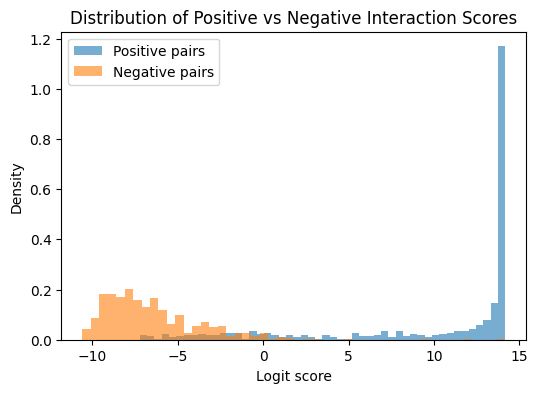

In [16]:
plt.figure(figsize=(6, 4))
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")
plt.legend()
plt.show()

#### non-dimers

In [17]:
interaction_scores = []
for batch in tqdm(non_dimers_dataloader, total=round(len(non_dimers_Df)/10), desc="#Iterating through batched data"):
    b_emb, t_emb, contacts_pep, contacts_prot, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():

        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
        prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]
        
        positive_logits = model(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], contacts_pep[rows,:,:], contacts_prot[cols,:,:], int_prob=0.0)
        negative_logits = model(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
        
        # print(logit_matrix)
        interaction_scores_pos.append(positive_logits)
        interaction_scores_neg.append(negative_logits)

# Convert list of tensors to single 1D tensors
pos_logits = torch.cat(interaction_scores_pos).detach().cpu().numpy()
neg_logits = torch.cat(interaction_scores_neg).detach().cpu().numpy()
print("Positives:", pos_logits.shape)
print("Negatives:", neg_logits.shape)

#Iterating through batched data: 41it [00:04, 10.11it/s]                                                                      

Positives: (616,)
Negatives: (614,)


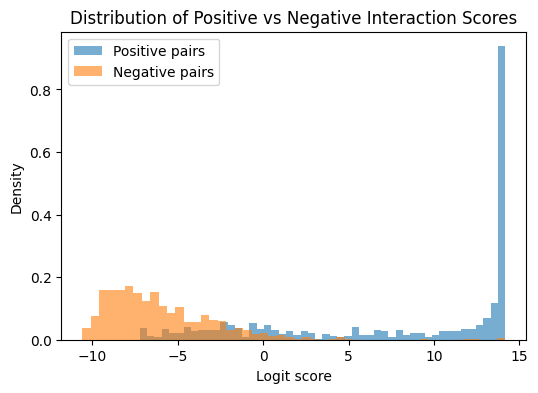

In [18]:
plt.figure(figsize=(6, 4))
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")
plt.legend()
plt.show()

#### meta-binders

In [19]:
# Loading batches
interaction_scores = []

for batch in tqdm(validation_dataloader, total = round(len(interaction_df_shuffled)/10),  desc= "#Iterating through batched data"):
    b_emb, t_emb, contacts_pep, contacts_prot, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():
        positive_logits = model(b_emb, t_emb, contacts_pep, contacts_prot)
        interaction_scores.append(positive_logits.unsqueeze(0))

predicted_interaction_scores = np.concatenate([batch_score.cpu().detach().numpy().reshape(-1,) for batch_score in interaction_scores])
interaction_probabilities = np.concatenate([torch.sigmoid(batch_score[0]).cpu().numpy() for batch_score in interaction_scores])

pos_logits, neg_logits = [], []
for i, row in interaction_df_shuffled.iterrows():
    logit = predicted_interaction_scores[i]
    if row.binder_label == False:
        neg_logits.append(logit)
    elif row.binder_label == True:
        pos_logits.append(logit)

#Iterating through batched data: 707it [01:20,  8.78it/s]                                                                     


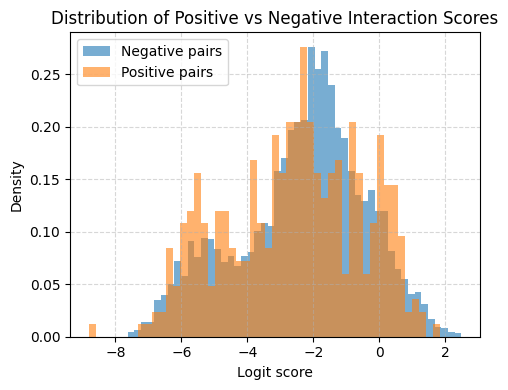

In [20]:
plt.figure(figsize=(5, 4))
plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")
# --- Simple grid behind ---
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Dilated CNN

In [37]:
class CLIP_PPint_class_w_contacts(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim=1280,
        embedding_pad_value=-5000.0,
        structure_pad_value=0.0,   # now used for raw cmaps
        fixed_max_blen=None,
        fixed_max_tlen=None,
    ):
        super().__init__()

        self.dframe = dframe.copy()
        self.embedding_dim = embedding_dim
        self.emb_pad = float(embedding_pad_value)
        self.struct_pad = float(structure_pad_value)

        # paths
        self.emb_path, self.cont_path = paths

        # lengths
        self.max_blen = self.dframe["pdb_binder_len"].max()+2
        self.max_tlen = self.dframe["pdb_target_len"].max()+2

        # index & storage
        self.dframe.set_index("interface_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):
            tgt_id = accession.split("_")[0]+"_"+str(self.dframe.loc[accession].target_chain)
            bnd_id = accession.split("_")[0]+"_"+str(self.dframe.loc[accession].binder_chain)

            # laod embeddings
            t_emb = np.load(os.path.join(self.emb_path, f"{tgt_id}.npy"))     # [Lt, D]
            b_emb = np.load(os.path.join(self.emb_path, f"{bnd_id}.npy"))     # [Lb, D]

            # print(b_emb.shape[0], self.dframe.loc[accession].seq_binder_len)
            assert (b_emb.shape[0] == self.dframe.loc[accession].pdb_binder_len+2)
            assert (t_emb.shape[0] == self.dframe.loc[accession].pdb_target_len+2)

            # sanity check
            if t_emb.shape[1] != embedding_dim or b_emb.shape[1] != embedding_dim:
                raise ValueError("Embedding dim mismatch.")

            # pad to global max
            t_emb = self._pad_embedding(t_emb, self.max_tlen)
            b_emb = self._pad_embedding(b_emb, self.max_blen)

            # ---------------- RAW CONTACT MAPS ----------------
            # they are variable-size [L, L]
            t_cmap = torch.from_numpy(
                np.load(os.path.join(self.cont_path, f"{tgt_id}.npy"))
            ).float()

            b_cmap = torch.from_numpy(
                np.load(os.path.join(self.cont_path, f"{bnd_id}.npy"))
            ).float()

            # DO NOT unfold or flatten → keep raw
            # DO NOT pad here → return list of unpadded maps

            self.samples.append((b_emb, t_emb, b_cmap, t_cmap))

    # ----------------------------------------------------
    # PAD EMBEDDINGS
    # ----------------------------------------------------
    def _pad_embedding(self, arr, max_len):
        L, D = arr.shape
        if L < max_len:
            pad = np.full((max_len - L, D), self.emb_pad, dtype=arr.dtype)
            arr = np.concatenate([arr, pad], axis=0)
        else:
            arr = arr[:max_len]
        return arr

    # ----------------------------------------------------
    # DATASET API
    # ----------------------------------------------------
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_emb, t_emb, b_cmap, t_cmap = self.samples[idx]

        b_emb = torch.from_numpy(b_emb).float()
        t_emb = torch.from_numpy(t_emb).float()

        # labels optional → default 1 for PPI-pairs?
        label = torch.tensor(1.0)

        return b_emb, t_emb, b_cmap, t_cmap, label

    # ----------------------------------------------------
    # GET MULTIPLE BY NAME
    # ----------------------------------------------------
    def _get_by_name(self, name):
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])

        out = [self.__getitem__(self.name_to_row[n]) for n in name]

        b_list, t_list, bmap_list, tmap_list, lbl_list = zip(*out)

        b      = torch.stack(b_list)
        t      = torch.stack(t_list)
        labels = torch.stack(lbl_list)

        # return raw cmaps unchanged
        return b, t, list(bmap_list), list(tmap_list), labels

In [38]:
emb_path = "/work3/s232958/data/PPint_DB/embeddings_esm2"
cont_path = "/work3/s232958/data/PPint_DB/contacts_esm2"

testing_Dataset = CLIP_PPint_class_w_contacts(
    Df_test,
    paths=[emb_path, cont_path],
    embedding_dim=1280
)

non_dimers_Df = Df_test[~Df_test["dimer"]]

non_dimers_Dataset = CLIP_PPint_class_w_contacts(
    non_dimers_Df,
    paths=[emb_path, cont_path],
    embedding_dim=1280
)

#Loading ESM2 embeddings and contacts: 100%|████████████████████████████████████████████████| 122/122 [00:01<00:00, 93.40it/s]


In [28]:
class CLIP_Meta_class(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim=1280,
        embedding_pad_value=-5000.0,
        structure_pad_value=0.0,
        fixed_max_blen=None,
        fixed_max_tlen=None,
    ):
        super().__init__()

        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        self.emb_pad = float(embedding_pad_value)
        self.struct_pad = float(structure_pad_value)

        # paths
        self.bemb_path, self.temb_path, self.bcont_path, self.tcont_path = paths

        # lengths
        self.max_blen = self.dframe["seq_binder_len"].max()+2
        self.max_tlen = self.dframe["seq_target_len"].max()+2

        # index & bookkeeping
        self.dframe.set_index("binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}

        self.samples = []

        # ------------------------------------------------------------
        # LOAD ALL SAMPLES
        # ------------------------------------------------------------
        for accession in tqdm(self.accessions, desc="#Loading ESM2 embeddings + raw cmaps"):
            label = torch.tensor(int(self.dframe.loc[accession, "binder_label"]))

            parts = accession.split("_")
            tgt_id = "_".join(parts[:-1])
            bnd_id = accession

            # laod embeddings
            t_emb = np.load(os.path.join(self.temb_path, f"{tgt_id}.npy")) # [Lt, D]
            b_emb = np.load(os.path.join(self.bemb_path, f"{bnd_id}.npy")) # [Lb, D]
            
            assert (b_emb.shape[0] == self.dframe.loc[accession].seq_binder_len+2)
            assert (t_emb.shape[0] == self.dframe.loc[accession].seq_target_len+2)

            # validate dims
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch in dataset.")

            # loading maps
            t_cmap = torch.from_numpy(np.load(os.path.join(self.tcont_path, f"{tgt_id}.npy"))).float()   # [Lt, Lt]
            b_cmap = torch.from_numpy(np.load(os.path.join(self.bcont_path, f"{bnd_id}.npy"))).float()   # [Lb, Lb]

            assert (b_emb.shape[0] == b_cmap.shape[0]+2)
            assert (t_emb.shape[0] == t_cmap.shape[0]+2)

            # pad embeddings to global length
            t_emb = self._pad_embedding(t_emb, self.max_tlen)
            b_emb = self._pad_embedding(b_emb, self.max_blen)

            # store raw contact maps (no unfold, no patches)
            self.samples.append((b_emb, t_emb, b_cmap, t_cmap, label))

    # ------------------------------------------------------------
    # PAD ESM2 EMBEDDINGS
    # ------------------------------------------------------------
    def _pad_embedding(self, arr, max_len):
        L, D = arr.shape
        if L < max_len:
            pad = np.full((max_len - L, D), self.emb_pad, dtype=arr.dtype)
            arr = np.concatenate([arr, pad], axis=0)
        else:
            arr = arr[:max_len]
        return arr

    # ------------------------------------------------------------
    # DATASET API
    # ------------------------------------------------------------
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_emb, t_emb, b_cmap, t_cmap, label = self.samples[idx]

        b_emb = torch.from_numpy(b_emb).float()
        t_emb = torch.from_numpy(t_emb).float()

        return b_emb, t_emb, b_cmap, t_cmap, label.float()

    # ------------------------------------------------------------
    # Fetch multiple items by name
    # ------------------------------------------------------------
    def _get_by_name(self, names):
        if isinstance(names, str):
            return self.__getitem__(self.name_to_row[names])

        items = [self.__getitem__(self.name_to_row[n]) for n in names]

        b_list, t_list, bmap_list, tmap_list, lbl_list = zip(*items)

        b = torch.stack(b_list)
        t = torch.stack(t_list)
        labels = torch.stack(lbl_list)

        # cmaps remain variable-size lists
        return b, t, list(bmap_list), list(tmap_list), labels

bemb_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_binders"
temb_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_targets"

## Contact maps paths
bcont_path = "/work3/s232958/data/meta_analysis/binders_contacts"
tcont_path = "/work3/s232958/data/meta_analysis/targets_contacts"

validation_Dataset = CLIP_Meta_class(
    interaction_df_shuffled,
    paths=[bemb_path, temb_path, bcont_path, tcont_path],
    embedding_dim=1280
)

#Loading ESM2 embeddings + raw cmaps: 100%|██████████████████████████████████████████████| 3532/3532 [00:30<00:00, 114.20it/s]


In [66]:
def collate_varlen(batch):
    b_emb = torch.stack([x[0] for x in batch], dim=0)  # fixed length -> stack
    t_emb = torch.stack([x[1] for x in batch], dim=0)
    b_ctok = [x[2] for x in batch]                     # var-len -> list
    t_ctok = [x[3] for x in batch]
    lbls = torch.tensor([x[4].float() for x in batch])
    return b_emb, t_emb, b_ctok, t_ctok, lbls

test_dataloader = DataLoader(testing_Dataset, batch_size=10, collate_fn=collate_varlen)
non_dimers_dataloader = DataLoader(non_dimers_Dataset, batch_size=10, collate_fn=collate_varlen)
validation_dataloader = DataLoader(validation_Dataset, batch_size=10, shuffle=False, drop_last = False, collate_fn=collate_varlen)

### Pre-trained model

In [40]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    """
    Purpose: return vector indicating which rows are not padded (don't have values = -5000)
    """
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1280] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

def pad_contact_maps(contact_list, pad_value=0.0):
    """
    contact_list: list of [L, L] or [1, L, L] tensors
    Returns: [B, 1, Lmax, Lmax]
    """
    # Ensure shape is [1, L, L]
    normalized = []
    for cm in contact_list:
        if cm.dim() == 2:
            cm = cm.unsqueeze(0)    # → [1, L, L]
        normalized.append(cm)

    # Find largest L
    Lmax = max(cm.shape[-1] for cm in normalized)

    padded_list = []
    for cm in normalized:
        L = cm.shape[-1]
        pad_amt = Lmax - L
        # Pad to the right and bottom: (left, right, top, bottom)
        padded = F.pad(cm, (0, pad_amt, 0, pad_amt), value=pad_value)
        padded_list.append(padded)

    # Stack → [B, 1, Lmax, Lmax]
    return torch.stack(padded_list, dim=0)

In [41]:
class ContactCNN_Dilated(nn.Module):
    """
    DeepCov-like dilated CNN
    Best for capturing long-range structure.
    """
    def __init__(self, in_channels=1, base_channels=64, d_model=320):
        super().__init__()
        C = base_channels

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, C, kernel_size=3, padding=1, dilation=1),
            nn.ReLU())
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=3, padding=2, dilation=2),
            nn.ReLU())
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=3, padding=4, dilation=4),
            nn.ReLU())
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=3, padding=8, dilation=8),
            nn.ReLU())
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(C, C, kernel_size=3, padding=16, dilation=16),
            nn.ReLU())

        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.project = nn.Linear(C * 4 * 4, d_model)

    def forward(self, x):
        h = self.conv1(x)
        h = self.conv2(h)
        h = self.conv3(h)
        h = self.conv4(h)
        h = self.conv5(h)
        h = self.pool(h)
        h = h.flatten(start_dim=1)
        return self.project(h)

class Fusion(nn.Module):
    def __init__(self, d_model=320):
        super().__init__()

        self.alpha = nn.Parameter(torch.tensor(0.0))
        self.norm = nn.LayerNorm(d_model)

    def forward(self, seq_embed, conv_struct):
        return self.norm(seq_embed + conv_struct * torch.tanh(self.alpha))

In [42]:
class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(
        self,
        padding_value=-5000,
        seq_embed_dimension = 1280,
        struct_embed_dimension = 256,
        num_recycles=2
    ):
        super().__init__()
        self.num_recycles = num_recycles # 2
        self.padding_value = padding_value # -5000
        self.seq_embed_dimension = seq_embed_dimension # 1280
        self.struct_embed_dimension = struct_embed_dimension # 256

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init
        self.struct_alpha = nn.Parameter(torch.tensor(0.0))

        self.fusion = Fusion(d_model=320)

        ### SEQUENCE ###
        # self attention
        self.seq_encoder = nn.TransformerEncoderLayer(d_model=self.seq_embed_dimension, nhead=8, dropout=0.1, batch_first=True, dim_feedforward=self.seq_embed_dimension)
        self.norm_seq = nn.LayerNorm(self.seq_embed_dimension)  # For residual additions
        # cross attention
        self.seq_cross_attn = nn.MultiheadAttention(embed_dim=self.seq_embed_dimension, num_heads=8, dropout=0.1, batch_first=True)
        self.projection_head= nn.Sequential(nn.Linear(self.seq_embed_dimension, 640), nn.ReLU(), nn.Linear(640, 320))

        ### STRUCTURE ###        
        # Linear projection of flat patches
        # self.contact_encoder = ContactCNN(in_channels=1, channels=64, d_model=320)
        self.contact_encoder = ContactCNN_Dilated(in_channels=1, base_channels=64, d_model=320)
                
    def forward(self, pep_emb, prot_emb, pep_contacts_list, prot_contacts_list, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True):
        
        pep_cmaps = pad_contact_maps(pep_contacts_list)  # [B, 1, Lmax, Lmax]
        prot_cmaps = pad_contact_maps(prot_contacts_list)  # [B, 1, Lmax, Lmax]
        
        # Key padding masks (True = pad -> to be ignored by attention)
        pep_mask_emb = create_key_padding_mask(embeddings = pep_emb, padding_value = self.padding_value).to(device)   # [B, Lp]
        prot_mask_emb = create_key_padding_mask(embeddings = prot_emb, padding_value = self.padding_value).to(device)    # [B, Lt]
    
        # Residual states
        pep_emb, prot_emb = pep_emb.to(device), prot_emb.to(device)
        pep_cmaps, prot_cmaps = pep_cmaps.to(device), prot_cmaps.to(device)
        pep_emb = pep_emb.clone()
        prot_emb = prot_emb.clone()

        for _ in range(self.num_recycles):

            # Self-attention on sequences
            pep_trans = self.seq_encoder(self.norm_seq(pep_emb), src_key_padding_mask=pep_mask_emb)
            prot_trans = self.seq_encoder(self.norm_seq(prot_emb), src_key_padding_mask=prot_mask_emb)

            # Cross attention
            pep_cross, _ = self.seq_cross_attn(self.norm_seq(pep_trans), self.norm_seq(prot_trans), self.norm_seq(prot_trans), key_padding_mask=prot_mask_emb)
            prot_cross, _ = self.seq_cross_attn(self.norm_seq(prot_trans), self.norm_seq(pep_trans), self.norm_seq(pep_trans), key_padding_mask=pep_mask_emb)

            pep_emb = pep_emb + pep_cross
            prot_emb = prot_emb + prot_cross

        # Pool over true tokens
        pep_seq_vec = create_mean_of_non_masked(pep_emb, pep_mask_emb)
        prot_seq_vec = create_mean_of_non_masked(prot_emb, prot_mask_emb)

        # Projections + L2-normalize
        pep_full   = F.normalize(self.projection_head(pep_seq_vec),   dim=-1) # [B, 320]
        prot_full  = F.normalize(self.projection_head(prot_seq_vec),  dim=-1) # [B, 320]

        # --- ContactsCNN (structure streams) ---
        pep_cnn = F.normalize(self.contact_encoder(pep_cmaps))   # [B, 320]
        prot_cnn = F.normalize(self.contact_encoder(prot_cmaps))  # [B, 320]

        pep_full = self.fusion(pep_full, pep_cnn)
        prot_full = self.fusion(prot_full, prot_cnn)
    
        if mem_save:
            torch.cuda.empty_cache()
    
        scale  = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_full * prot_full).sum(dim=-1)  # [B]
        
        return logits

    def training_step(self, batch, device):
        embedding_pep, embedding_prot, contacts_pep, contacts_prot, labels = batch
        # embedding_pep, embedding_prot, contacts_pep, contacts_prot = embedding_pep.to(device), embedding_prot.to(device), contacts_pep.to(device), contacts_prot.to(device)

        # loss of predicting partner using peptide
        positive_logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
        positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device)) # F.binary_cross_entropy_with_logits does sigmoid transfromation inside, excepts data, labels
        
        # Negative indexes
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1) # upper triangle
        
        pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
        prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]

        # loss of predicting peptide using partner
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], contacts_pep[rows,:,:], contacts_prot[cols,:,:], int_prob=0.0)
        negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
        negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))
        
        loss = (positive_loss + negative_loss) / 2
 
        # del partner_prediction_loss, peptide_prediction_loss, embedding_pep, embedding_prot
        torch.cuda.empty_cache()
        return loss

    def validation_step_PPint(self, batch, device):
        # Predict on random batches of training batch size
        embedding_pep, embedding_prot, contacts_pep, contacts_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        # contacts_pep, contacts_prot = contacts_pep.to(device), contacts_prot.to(device)
        
        with torch.no_grad():

            positive_logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
            
            # loss of predicting partner using peptide
            positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
            
            # Negaive indexes
            rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1)
            
            pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
            prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]
            
            negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
            negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))

            loss = (positive_loss + negative_loss) / 2

            logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
            logit_matrix[rows, cols] = negative_logits
            logit_matrix[cols, rows] = negative_logits
            
            # Fill diagonal with positive scores
            diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
            logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()

            labels = torch.arange(embedding_prot.size(0)).to(self.device)
            peptide_predictions = logit_matrix.argmax(dim=0)
            peptide_ranks = logit_matrix.argsort(dim=0).diag() + 1
            peptide_mrr = (peptide_ranks).float().pow(-1).mean()
            
            # partner_accuracy = partner_predictions.eq(labels).float().mean()
            peptide_accuracy = peptide_predictions.eq(labels).float().mean()
    
            del logit_matrix,positive_logits,negative_logits,embedding_pep,embedding_prot

            return loss, peptide_accuracy
    
    def validation_step_MetaDataset(self, batch, device):
        embedding_pep, embedding_prot, contacts_pep, contacts_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        # contacts_pep, contacts_prot = contacts_pep.to(device), contacts_prot.to(device)
        labels = labels.to(device).float()
    
        with torch.no_grad():
            logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot).float()
            loss = F.binary_cross_entropy_with_logits(logits.view(-1), labels.view(-1))
            return logits, loss

    def calculate_logit_matrix(self, embedding_pep, embedding_prot, contacts_pep, contacts_prot):
        
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
        prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]
        
        positive_logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], contacts_pep[rows,:,:], contacts_prot[cols,:,:], int_prob=0.0)
        negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        return logit_matrix

In [43]:
model = MiniCLIP_w_transformer_crossattn().to("cuda")
path = "/work3/s232958/data/trained/with_structure/1b91a6ec-7bfe-4982-84b1-cb13d18cd284/1b91a6ec-7bfe-4982-84b1-cb13d18cd284_checkpoint_9/1b91a6ec-7bfe-4982-84b1-cb13d18cd284_checkpoint_epoch_9.pth"
checkpoint = torch.load(path, weights_only=False, map_location=torch.device('cpu'))
# print(list(checkpoint["model_state_dict"]))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()  

MiniCLIP_w_transformer_crossattn(
  (fusion): Fusion(
    (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
  )
  (seq_encoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
    )
    (linear1): Linear(in_features=1280, out_features=1280, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1280, out_features=1280, bias=True)
    (norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm_seq): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  (seq_cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
  )
  (projection_head): Sequential(
    (0): Linear(in_features=1280, 

#### test-dataset

In [44]:
interaction_scores_pos = []
interaction_scores_neg = []    

for batch in tqdm(test_dataloader, total=round(len(Df_test)/10), desc="#Iterating through batched data"):
    b_emb, t_emb, contacts_pep, contacts_prot, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():

        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
        prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]
        
        positive_logits = model(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], contacts_pep[rows,:,:], contacts_prot[cols,:,:], int_prob=0.0)
        negative_logits = model(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
        
        # print(logit_matrix)
        interaction_scores_pos.append(positive_logits)
        interaction_scores_neg.append(negative_logits)

# Convert list of tensors to single 1D tensors
pos_logits = torch.cat(interaction_scores_pos).detach().cpu().numpy()
neg_logits = torch.cat(interaction_scores_neg).detach().cpu().numpy()
print("Positives:", pos_logits.shape)
print("Negatives:", neg_logits.shape)

#Iterating through batched data: 50it [00:55,  1.11s/it]                                                                      

Positives: (494,)
Negatives: (2211,)


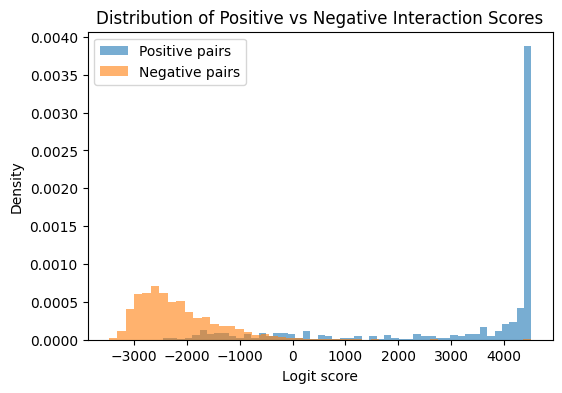

In [45]:
plt.figure(figsize=(6, 4))
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")
plt.legend()
plt.show()

#### non-dimers datset

In [46]:
interaction_scores = []
for batch in tqdm(non_dimers_dataloader, total=round(len(non_dimers_Df)/10), desc="#Iterating through batched data"):
    b_emb, t_emb, contacts_pep, contacts_prot, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():

        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
        prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]
        
        positive_logits = model(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], contacts_pep[rows,:,:], contacts_prot[cols,:,:], int_prob=0.0)
        negative_logits = model(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
        
        # print(logit_matrix)
        interaction_scores_pos.append(positive_logits)
        interaction_scores_neg.append(negative_logits)

# Convert list of tensors to single 1D tensors
pos_logits = torch.cat(interaction_scores_pos).detach().cpu().numpy()
neg_logits = torch.cat(interaction_scores_neg).detach().cpu().numpy()
print("Positives:", pos_logits.shape)
print("Negatives:", neg_logits.shape)

#Iterating through batched data: 13it [00:12,  1.08it/s]                                                                      

Positives: (616,)
Negatives: (2752,)


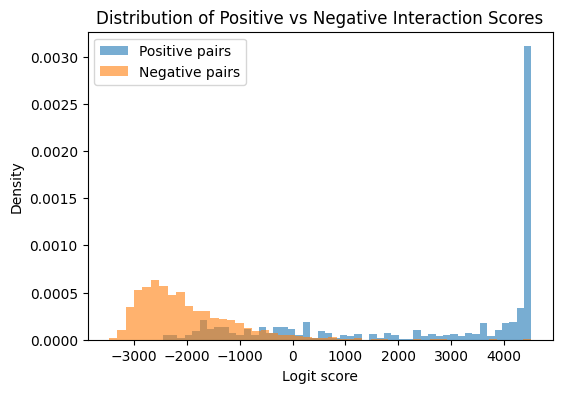

In [47]:
plt.figure(figsize=(6, 4))
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")
plt.legend()
plt.show()

#### meta-analysis dataset

In [48]:
# Loading batches
interaction_scores = []

for batch in tqdm(validation_dataloader, total = round(len(interaction_df_shuffled)/10),  desc= "#Iterating through batched data"):
    b_emb, t_emb, contacts_pep, contacts_prot, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():
        positive_logits = model(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
        interaction_scores.append(positive_logits.unsqueeze(0))

predicted_interaction_scores = np.concatenate([batch_score.cpu().detach().numpy().reshape(-1,) for batch_score in interaction_scores])
interaction_probabilities = np.concatenate([torch.sigmoid(batch_score[0]).cpu().numpy() for batch_score in interaction_scores])

pos_logits, neg_logits = [], []
for i, row in interaction_df_shuffled.iterrows():
    logit = predicted_interaction_scores[i]
    if row.binder_label == False:
        neg_logits.append(logit)
    elif row.binder_label == True:
        pos_logits.append(logit)

#Iterating through batched data: 354it [01:38,  3.60it/s]                                                                     


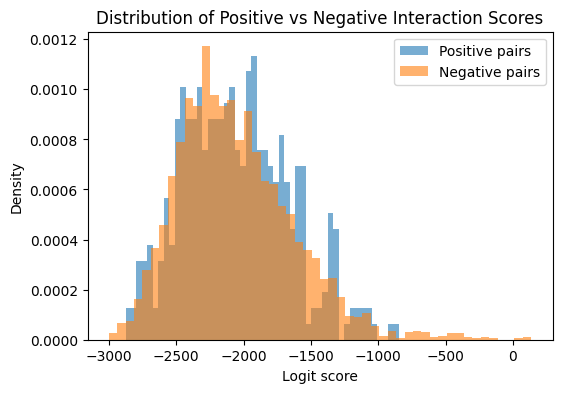

In [49]:
plt.figure(figsize=(6, 4))
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")
plt.legend()
plt.show()

## Simple CNN

In [59]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=1, channels=32, d_model=320):
        super().__init__()
        c = channels

        def block(cin, cout, stride=1):
            return nn.Sequential(
                nn.Conv2d(cin, cout, kernel_size=3, padding=1, stride=stride, bias=False),
                nn.BatchNorm2d(cout),
                nn.ReLU(inplace=True),
            )

        self.convolution = nn.Sequential(
            block(in_channels, c,   stride=2),   # L -> L/2
            block(c,          c*2,  stride=2),   # L/2 -> L/4
            block(c*2,        c*4,  stride=2),   # L/4 -> L/8
            block(c*4,        c*8,  stride=2),   # L/8 -> L/16
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.project = nn.Linear(c*8, d_model)

    def forward(self, x):
        h = self.convolution(x)              # [B, c*8, ~L/16, ~L/16]
        h = self.pool(h).flatten(1)          # [B, c*8]
        return self.project(h)               # [B, d_model]

In [60]:
seq_embed_dimension = 1280

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(
        self,
        padding_value=-5000,
        seq_embed_dimension = seq_embed_dimension,
        num_recycles=2
    ):
        super().__init__()
        self.num_recycles = num_recycles # 2
        self.padding_value = padding_value # -5000
        self.seq_embed_dimension = seq_embed_dimension # 1280

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init
        self.struct_alpha = nn.Parameter(torch.tensor(0.0))

        self.fusion = Fusion(d_model=320)

        ### SEQUENCE ###
        # self attention
        self.seq_encoder = nn.TransformerEncoderLayer(d_model=self.seq_embed_dimension, nhead=8, dropout=0.1, batch_first=True, dim_feedforward=self.seq_embed_dimension)
        self.norm_seq = nn.LayerNorm(self.seq_embed_dimension)  # For residual additions
        
        # cross attention
        self.seq_cross_attn = nn.MultiheadAttention(embed_dim=self.seq_embed_dimension, num_heads=8, dropout=0.1, batch_first=True)
        self.projection_head= nn.Sequential(nn.Linear(self.seq_embed_dimension, 640), nn.ReLU(), nn.Linear(640, 320))

        ### STRUCTURE ###        
        # Linear projection of flat patches
        self.contact_encoder = SimpleCNN(in_channels=1, channels=32, d_model=320)
                
    def forward(self, pep_emb, prot_emb, pep_contacts_list, prot_contacts_list, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True):
        
        pep_cmaps = pad_contact_maps(pep_contacts_list)  # [B, 1, Lmax, Lmax]
        prot_cmaps = pad_contact_maps(prot_contacts_list)  # [B, 1, Lmax, Lmax]
        device = pep_emb.device
        
        # Key padding masks (True = pad -> to be ignored by attention)
        pep_mask_emb = create_key_padding_mask(embeddings = pep_emb, padding_value = self.padding_value).to(device)   # [B, Lp]
        prot_mask_emb = create_key_padding_mask(embeddings = prot_emb, padding_value = self.padding_value).to(device)    # [B, Lt]
    
        # Residual states
        pep_emb, prot_emb = pep_emb.to(device).clone(), prot_emb.to(device).clone()
        pep_cmaps, prot_cmaps = pep_cmaps.to(device).clone(), prot_cmaps.to(device).clone()

        for _ in range(self.num_recycles):

            # Self-attention on sequences
            pep_trans = self.seq_encoder(self.norm_seq(pep_emb), src_key_padding_mask=pep_mask_emb)
            prot_trans = self.seq_encoder(self.norm_seq(prot_emb), src_key_padding_mask=prot_mask_emb)

            # Cross attention
            pep_cross, _ = self.seq_cross_attn(self.norm_seq(pep_trans), self.norm_seq(prot_trans), self.norm_seq(prot_trans), key_padding_mask=prot_mask_emb)
            prot_cross, _ = self.seq_cross_attn(self.norm_seq(prot_trans), self.norm_seq(pep_trans), self.norm_seq(pep_trans), key_padding_mask=pep_mask_emb)

            pep_emb = pep_emb + pep_cross
            prot_emb = prot_emb + prot_cross

        # Pool over true tokens
        pep_seq_vec = create_mean_of_non_masked(pep_emb, pep_mask_emb)
        prot_seq_vec = create_mean_of_non_masked(prot_emb, prot_mask_emb)

        pep_full   = self.projection_head(pep_seq_vec) # [B, 320]
        prot_full  = self.projection_head(prot_seq_vec)# [B, 320]

        # --- ContactsCNN (structure streams) ---
        pep_cnn = self.contact_encoder(pep_cmaps)   # [B, 320]
        prot_cnn = self.contact_encoder(prot_cmaps)  # [B, 320]

        pep_full = F.normalize(self.fusion(pep_full, pep_cnn), dim=-1)
        prot_full = F.normalize(self.fusion(prot_full, prot_cnn), dim=-1)
    
        if mem_save:
            torch.cuda.empty_cache()
    
        scale  = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_full * prot_full).sum(dim=-1)  # [B]
        
        return logits

    def training_step(self, batch, device):
        embedding_pep, embedding_prot, contacts_pep, contacts_prot, labels = batch
        # embedding_pep, embedding_prot, contacts_pep, contacts_prot = embedding_pep.to(device), embedding_prot.to(device), contacts_pep.to(device), contacts_prot.to(device)

        # loss of predicting partner using peptide
        positive_logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
        positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device)) # F.binary_cross_entropy_with_logits does sigmoid transfromation inside, excepts data, labels
        
        # Negative indexes
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1) # upper triangle
        
        pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
        prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]

        # loss of predicting peptide using partner
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], contacts_pep[rows,:,:], contacts_prot[cols,:,:], int_prob=0.0)
        negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
        negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))
        
        loss = (positive_loss + negative_loss) / 2
 
        # del partner_prediction_loss, peptide_prediction_loss, embedding_pep, embedding_prot
        torch.cuda.empty_cache()
        return loss

    def validation_step_PPint(self, batch, device):
        # Predict on random batches of training batch size
        embedding_pep, embedding_prot, contacts_pep, contacts_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        # contacts_pep, contacts_prot = contacts_pep.to(device), contacts_prot.to(device)
        
        with torch.no_grad():

            positive_logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
            
            # loss of predicting partner using peptide
            positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
            
            # Negaive indexes
            rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1)
            
            pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
            prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]
            
            negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
            negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))

            loss = (positive_loss + negative_loss) / 2

            logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
            logit_matrix[rows, cols] = negative_logits
            logit_matrix[cols, rows] = negative_logits
            
            # Fill diagonal with positive scores
            diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
            logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()

            labels = torch.arange(embedding_prot.size(0)).to(self.device)
            peptide_predictions = logit_matrix.argmax(dim=0)
            peptide_ranks = logit_matrix.argsort(dim=0).diag() + 1
            peptide_mrr = (peptide_ranks).float().pow(-1).mean()
            
            # partner_accuracy = partner_predictions.eq(labels).float().mean()
            peptide_accuracy = peptide_predictions.eq(labels).float().mean()
    
            del logit_matrix,positive_logits,negative_logits,embedding_pep,embedding_prot

            return loss, peptide_accuracy
    
    def validation_step_MetaDataset(self, batch, device):
        embedding_pep, embedding_prot, contacts_pep, contacts_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        # contacts_pep, contacts_prot = contacts_pep.to(device), contacts_prot.to(device)
        labels = labels.to(device).float()
    
        with torch.no_grad():
            logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot).float()
            loss = F.binary_cross_entropy_with_logits(logits.view(-1), labels.view(-1))
            return logits, loss

    def calculate_logit_matrix(self, embedding_pep, embedding_prot, contacts_pep, contacts_prot):
        
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
        prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]
        
        positive_logits = self.forward(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], contacts_pep[rows,:,:], contacts_prot[cols,:,:], int_prob=0.0)
        negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        return logit_matrix

In [61]:
model = MiniCLIP_w_transformer_crossattn().to("cuda")
path = "/work3/s232958/data/trained/with_structure/1b3d5c1d-4063-440a-bd96-ca9b118f3d47/1b3d5c1d-4063-440a-bd96-ca9b118f3d47_checkpoint_9/1b3d5c1d-4063-440a-bd96-ca9b118f3d47_checkpoint_epoch_9.pth"
checkpoint = torch.load(path, weights_only=False, map_location=torch.device('cpu'))
# print(list(checkpoint["model_state_dict"]))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()  

MiniCLIP_w_transformer_crossattn(
  (fusion): Fusion(
    (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
  )
  (seq_encoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
    )
    (linear1): Linear(in_features=1280, out_features=1280, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1280, out_features=1280, bias=True)
    (norm1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm_seq): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  (seq_cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1280, out_features=1280, bias=True)
  )
  (projection_head): Sequential(
    (0): Linear(in_features=1280, 

#### test-dataset

#Iterating through batched data: 50it [00:24,  2.07it/s]                                                                      


Positives: (494,)
Negatives: (2211,)


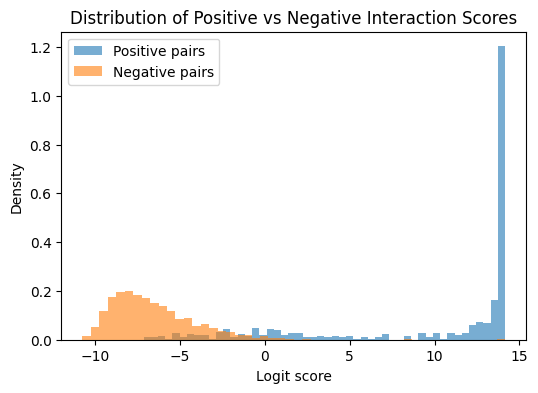

In [63]:
interaction_scores_pos = []
interaction_scores_neg = []    

for batch in tqdm(test_dataloader, total=round(len(Df_test)/10), desc="#Iterating through batched data"):
    b_emb, t_emb, contacts_pep, contacts_prot, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():

        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
        prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]
        
        positive_logits = model(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], contacts_pep[rows,:,:], contacts_prot[cols,:,:], int_prob=0.0)
        negative_logits = model(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
        
        # print(logit_matrix)
        interaction_scores_pos.append(positive_logits)
        interaction_scores_neg.append(negative_logits)

# Convert list of tensors to single 1D tensors
pos_logits = torch.cat(interaction_scores_pos).detach().cpu().numpy()
neg_logits = torch.cat(interaction_scores_neg).detach().cpu().numpy()
print("Positives:", pos_logits.shape)
print("Negatives:", neg_logits.shape)

plt.figure(figsize=(6, 4))
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")
plt.legend()
plt.show()

#### non-dimer dataset

#Iterating through batched data: 13it [00:05,  2.26it/s]                                                                      


Positives: (616,)
Negatives: (2752,)


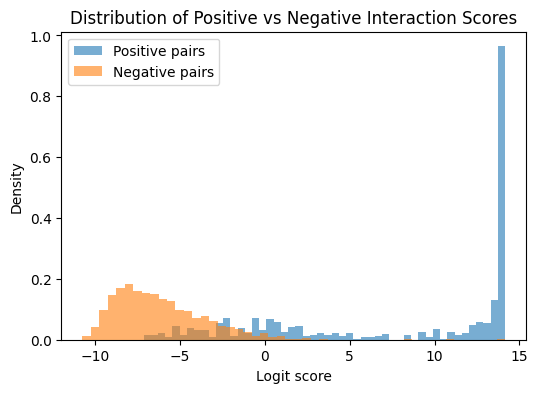

In [64]:
interaction_scores = []
for batch in tqdm(non_dimers_dataloader, total=round(len(non_dimers_Df)/10), desc="#Iterating through batched data"):
    b_emb, t_emb, contacts_pep, contacts_prot, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():

        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        pep_cm_list  = [contacts_pep[i] for i in rows.tolist()]  # list of [Li, 256]
        prot_cm_list = [contacts_prot[j] for j in cols.tolist()]  # list of [Lj, 256]
        
        positive_logits = model(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
        # negative_logits = self.forward(embedding_pep[rows,:,:], embedding_prot[cols,:,:], contacts_pep[rows,:,:], contacts_prot[cols,:,:], int_prob=0.0)
        negative_logits = model(embedding_pep[rows,:,:], embedding_prot[cols,:,:], pep_cm_list, prot_cm_list, int_prob=0.0)
        
        # print(logit_matrix)
        interaction_scores_pos.append(positive_logits)
        interaction_scores_neg.append(negative_logits)

# Convert list of tensors to single 1D tensors
pos_logits = torch.cat(interaction_scores_pos).detach().cpu().numpy()
neg_logits = torch.cat(interaction_scores_neg).detach().cpu().numpy()
print("Positives:", pos_logits.shape)
print("Negatives:", neg_logits.shape)

plt.figure(figsize=(6, 4))
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")
plt.legend()
plt.show()

#### meta-analysis dataset

#Iterating through batched data: 354it [00:39,  8.96it/s]                                                                     


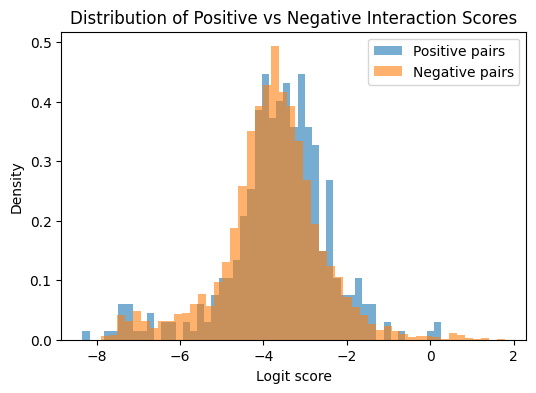

In [68]:
# Loading batches
interaction_scores = []

for batch in tqdm(validation_dataloader, total = round(len(interaction_df_shuffled)/10),  desc= "#Iterating through batched data"):
    b_emb, t_emb, contacts_pep, contacts_prot, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():
        positive_logits = model(embedding_pep, embedding_prot, contacts_pep, contacts_prot)
        interaction_scores.append(positive_logits.unsqueeze(0))

predicted_interaction_scores = np.concatenate([batch_score.cpu().detach().numpy().reshape(-1,) for batch_score in interaction_scores])
interaction_probabilities = np.concatenate([torch.sigmoid(batch_score[0]).cpu().numpy() for batch_score in interaction_scores])

pos_logits, neg_logits = [], []
for i, row in interaction_df_shuffled.iterrows():
    logit = predicted_interaction_scores[i]
    if row.binder_label == False:
        neg_logits.append(logit)
    elif row.binder_label == True:
        pos_logits.append(logit)

plt.figure(figsize=(6, 4))
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")
plt.legend()
plt.show()